In [13]:
##Import libraries
import pandas as pd
import matplotlib.pyplot as plt

## Context


If you like to read you know the bittersweet feeling of finishing a book, specially if you loved it. The happiness of having enjoyed a good story gets mixed with the sadness of leaving it behind, and the longing of finding new (fictional) adventure partners to fill the void. However, choosing is not always easy, is it? 

Being an avid reader and a newbie data analyst, I thought about diving a little bit more into the matter and try to find some ways of getting new interesting recommendations that could fulfill me. 

## Where to start: the data

The dataset goodbooks-10k, put together by Zygmunt Zajac, seemed a very good starting point for the analysis. It contains several CSV that contain, amongst other, the following information:

- Ratings: rating value per user and book
- Books: information on the books in the dataset, such as title, author, etc
- Tags: user-generated tags related to the books

The information is gathered from the Goodreads website.

#### Ratings

The ratings CSV contains 5976479 unique ratings, created by 53424 unique users on 10000 unique books. The data can be matched to  the information on the books CSV using the 'book_id' key.

<img style="float: centre;" src="screenshots/ratings_table.JPG" width="600"/>

#### Books

The books table contains 10000 unique entries, each one containing information about the book. After some inspection of the data, the following rows are kept:

- book_id: used as foreign key in the ratings table
- goodreads_book_id: used as foreign key in the tags table
- book_title: the title of the book, extracted from the original title column
- book_series: the series of the book (when part of a collection). Extracted from the original title column
- authors
- original_publication year: there are 21 missing values that are replaced by 0 to avoid NaN values.
- average_rating: the average rating of the book considering all users votes and all editions
- work_ratings_count: the total amount of user votes

<img style="float: centre;" src="screenshots/books_table.JPG" width="1200"/>

#### Tags

A first check on the descriptive statistics seems to indicate that keeping only a few tags we can provide some relevant extra information to our dataset. 

In [12]:
tags = pd.read_csv('datasets/gb10k_tags.csv')
books_tags = pd.read_csv('datasets/gb10k_book_tags.csv')
books_with_tags = pd.merge(books_tags, tags, on=['tag_id'])
books_per_tag = books_with_tags.groupby(['tag_id', 'tag_name'], as_index=False).count().drop(columns=['count']).rename(columns={'goodreads_book_id':'number_of_books'}).sort_values(by=['number_of_books'], ascending=False).reset_index(drop=True)
books_per_tag.describe()

,tag_id,number_of_books
count,34252.000000,34252.000000
mean,17125.500000,29.192806
std,9887.845047,277.254715
min,0.000000,1.000000
25%,8562.750000,1.000000
50%,17125.500000,1.000000
75%,25688.250000,5.000000
max,34251.000000,9983.000000


This is interesting as the tags are user generated and therefore will need to be manually reviewed and somehow normalized, a task that will prove very difficult for the total amount of tags (34252). However, we can see that more than more than 75% of our tags are associated to only 5 books at most. We can also see that the mean of books per tag is 30, which along with the previous data indicates that probaby there are a few outliers in our tags dataset that concentrate a lot of books. The following plot helps seeing that too:

<Figure size 720x288 with 0 Axes>

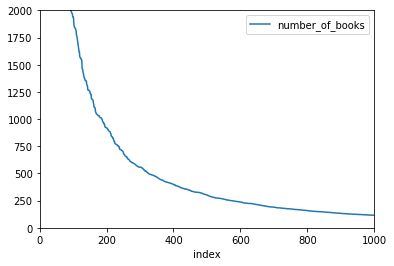

In [14]:
plt.figure(figsize=(10,4))
books_per_tag.reset_index().plot(x='index', y='number_of_books')
plt.ylim(0,2000)
plt.xlim(0,1000)
plt.show()

There seems to be quite a long tail in the tags, so roughly 200 tags qualify most of the books, and after that threshold tags seem to qualify only a small amount of books each. In order to make a final decision, it would be interesting to also check if ignoring that subset of tags will leave books underqualified:

In [15]:
number_of_tagged_books = [1500, 1250, 1000, 750, 500, 250]
for i in number_of_tagged_books:
    reduced_books_per_tag = books_per_tag.copy()
    reduced_books_per_tag = reduced_books_per_tag[reduced_books_per_tag.number_of_books > i]
    list_of_tags = reduced_books_per_tag.tag_id.unique().tolist()
    books_with_tags_reduced = books_with_tags.copy()
    books_with_tags_reduced = books_with_tags_reduced[books_with_tags_reduced.tag_id.isin(list_of_tags)]
    tags_per_book = books_with_tags_reduced.groupby(['goodreads_book_id'], as_index=False).count().drop(columns=['count', 'tag_name']).rename(columns={'tag_id':'number_of_tags'}).sort_values(by=['number_of_tags'], ascending=True).reset_index(drop=True)
    print('If we keep the most used', len(list_of_tags), 'tags, the less qualified book will have', tags_per_book.iloc[0, 1], 'related tags.')

If we keep the most used 127 tags, the less qualified book will have 10 related tags.
If we keep the most used 151 tags, the less qualified book will have 11 related tags.
If we keep the most used 186 tags, the less qualified book will have 12 related tags.
If we keep the most used 237 tags, the less qualified book will have 14 related tags.
If we keep the most used 325 tags, the less qualified book will have 17 related tags.
If we keep the most used 572 tags, the less qualified book will have 17 related tags.


The previous code proves that even with as little as 127 tags, all books will at least be related to 10 tags. Therefore only the most used 150 tags were taken into account for manual review. The cleaning process of the tags included several actions:

- Create consistency between tags, editing the ones that meant the same (i.e.: 'fantasy-sci-fi' and 'sci-fi-fantasy')
- Simplify tags when they refer to equal or similar concepts (i.e.: 'owned-books' and 'books-i-own')
- Classify tags according to it's content, as that may be important in the future analysis (i.e.: genre tags, status tags and type tags)
- Discard tags that seemed not relevant for the analysis (i.e.: 'literature')

The reviewed tags were merged with the original book-tag dataframe. The discarded tags, as well as the other long tail tags not considered in the review, were set to a general category.

<img style="float: centre;" src="screenshots/tags_table.JPG" width="500"/>

## EDA: some insigths

## Basic recommendations

When considering how to provide recommendations to users, the most simple and obvious option is to go for the best and most popular products. These metrics can be easily found in our dataset:

- Popularity: we consider that the more ratings (work_rating_counts) a book gets, the more popular it is.
- Quality: we consider that the higher the average rating (average_rating) of a book is, the better it is. The average rating is calculated by multiplying the number of ratings of each value per that value and then dividing that number by the total amount of ratings.

#### Top 10 rated books

In [38]:
all_books = pd.read_csv('datasets/clean_books.csv')
all_books.drop(columns=['Unnamed: 0'], inplace=True)
top_rated = all_books[['goodreads_book_id', 'book_title', 'average_rating']].sort_values(by='average_rating', ascending=False)
top_rated.head(10)

,goodreads_book_id,book_title,average_rating
3627,24812,The Complete Calvin and Hobbes,4.82
3274,8,"Harry Potter Boxed Set, Books 1-5",4.77
861,17332218,Words of Radiance,4.77
8853,95602,Mark of the Lion Trilogy,4.76
7946,5031805,ESV Study Bible,4.76
4482,24814,It's a Magical World: A Calvin and Hobbes Coll...,4.75
6360,70489,There's Treasure Everywhere: A Calvin and Hobb...,4.74
421,862041,Harry Potter Boxset,4.74
3752,10,Harry Potter Collection,4.73
6919,24815,The Indispensable Calvin and Hobbes,4.73


#### Top 10 most popular books

In [39]:
most_popular = all_books[['goodreads_book_id', 'book_title', 'work_ratings_count']].sort_values(by='work_ratings_count', ascending=False)
most_popular.head(10)

,goodreads_book_id,book_title,work_ratings_count
0,2767052,The Hunger Games,4942365
1,3,Harry Potter and the Sorcerer's Stone,4800065
2,41865,Twilight,3916824
3,2657,To Kill a Mockingbird,3340896
4,4671,The Great Gatsby,2773745
5,11870085,The Fault in Our Stars,2478609
11,13335037,Divergent,2216814
6,5907,The Hobbit,2196809
9,1885,Pride and Prejudice,2191465
7,5107,The Catcher in the Rye,2120637


When we check at this first analysis, we can see that the list of most rated books may not be the one we expected. This is because the average rating metric normally penalizes the books with more total ratings. Let's check, for instance, the first  book in each list:

In [41]:
most_popular = all_books[['goodreads_book_id', 'book_title', 'work_ratings_count', 'average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']].sort_values(by='work_ratings_count', ascending=False)
most_popular.head(1)

,goodreads_book_id,book_title,work_ratings_count,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,2767052,The Hunger Games,4942365,4.34,66715,127936,560092,1481305,2706317


In [42]:
most_rated = all_books[['goodreads_book_id', 'book_title', 'work_ratings_count', 'average_rating', 'ratings_1', 'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5',]].sort_values(by='average_rating', ascending=False)
most_rated.head(1)

,goodreads_book_id,book_title,work_ratings_count,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
3627,24812,The Complete Calvin and Hobbes,29968,4.82,120,154,693,3117,25884


In [43]:
print('')
print('The Hunger Games 5-star rating percentage over total is', (2706317/4942365)*100)
print('The Complete Calvin and Hobbes 5-star rating percentage over total is', (25884/29968)*100)


The Hunger Games 5-star rating percentage over total is 54.75753004887336
The Complete Calvin and Hobbes 5-star rating percentage over total is 86.37213027229045


Even though the percentage of users over the total that rated The Hunger Games with 5-stars is less than the one for The Complete Calvin and Hobbes, the total amount of people that rated The Hunger Games with 5-stars is much higher than the one for The Complete Calvin and Hobbes. Therefore, an algorithm that calculates a recommendation based on popularity and quality should take that into consideration. 

We are going to consider a weighted algorithm:

<img style="float: left;" src="screenshots/formula.JPG" width="400"/>

where:
- nr is the number of ratings that the book has
- mv is the minimum votes required to be listed
- ar is the average rating of the book
- mr is the mean rating across the whole dataset

Here the value for m is the element we can tune in order to decide how much we let our elements with low ratings to affect our final results. In this case, considering the distribution in the number of ratings, we consider a 90th percentile (meaning that in order for a book to be recommended, it needs to have more votes than at least 90% of the books). 

In [44]:
# Create a function to calculate the weighted rating
def w_rating(row, mv, mr):
    nr = row.work_ratings_count
    ar = row.average_rating
    return (nr/(nr+mv) * ar) + (mv/(mv+nr) * mr)

# Create a function to calculate a recommendation for all genres
def basic_recommendation(dataset, mv, mr):
    books_to_evaluate = dataset.copy()
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    return books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')


##Set main parameters
all_books = pd.read_csv('datasets/work_datasets/books_with_category.csv')
mv = all_books['work_ratings_count'].quantile(0.90)
mr = all_books['average_rating'].mean()

general_recommendations = basic_recommendation(all_books, mv, mr)
general_recommendations.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
Harry Potter,Harry Potter and the Deathly Hallows,4.577047,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Half-Blood Prince,4.509888,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Prisoner of Azkaban,4.503064,"J.K. Rowling, Mary GrandPré, Rufus Beck",fantasy
Harry Potter,Harry Potter and the Goblet of Fire,4.501689,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter Boxset,4.487955,J.K. Rowling,fantasy
A Song of Ice and Fire,A Storm of Swords,4.450089,George R.R. Martin,fantasy
The Kingkiller Chronicle,The Name of the Wind,4.445507,Patrick Rothfuss,fantasy
Harry Potter,Harry Potter and the Order of the Phoenix,4.435087,"J.K. Rowling, Mary GrandPré",fantasy
Harry Potter,Harry Potter and the Sorcerer's Stone,4.430547,"J.K. Rowling, Mary GrandPré",fantasy


This results show more balance between popularity and perceived quality, but we can quickly see that they are far from perfect. For instance, we can see that the first five results are part of the Harry Potter series, and for the user that can be frustrating, as it does not offer wide variety.

A possible way to tweak these results into a more varied ones would be to show only the first result of a series and drop the rest:

In [45]:
# Modify the function to exclude books from the same series
def basic_recommendation_exclude_series(dataset, mv, mr):
    books_to_evaluate = dataset.copy()
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    grouped = books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')
    grouped = grouped.loc[~grouped.index.duplicated(keep='first')]
    return grouped

recommendations_no_series = basic_recommendation_exclude_series(all_books, mv, mr)
recommendations_no_series.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
Harry Potter,Harry Potter and the Deathly Hallows,4.577047,"J.K. Rowling, Mary GrandPré",fantasy
A Song of Ice and Fire,A Storm of Swords,4.450089,George R.R. Martin,fantasy
The Kingkiller Chronicle,The Name of the Wind,4.445507,Patrick Rothfuss,fantasy
The Lord of the Rings,The Return of the King,4.422745,J.R.R. Tolkien,fantasy
NaN,The Help,4.422252,Kathryn Stockett,historical
The Infernal Devices,Clockwork Princess,4.414067,Cassandra Clare,fantasy
Percy Jackson and the Olympians,The Last Olympian,4.412904,Rick Riordan,fantasy
A Court of Thorns and Roses,A Court of Mist and Fury,4.392844,Sarah J. Maas,fantasy
The Stormlight Archive,The Way of Kings,4.390141,Brandon Sanderson,fantasy


This is already an improvement, but is also proves the bias we already noticed when analyzing the data provided in the dataset: Goodread users seem to love the fantasy genre! 

In case our user is not a fan, though, it would be interesting to offer the top titles for a certain category:

In [46]:
# Modify the function to include category
def recommendation_with_category(dataset, mv, mr, genre=None):
    if genre ==None: 
        books_to_evaluate = dataset.copy()
    else:
        books_to_evaluate = dataset.copy()
        books_to_evaluate = books_to_evaluate[books_to_evaluate.main_genre == genre]
    books_to_evaluate = books_to_evaluate[books_to_evaluate.work_ratings_count >= mv]
    books_to_evaluate['w_rating'] = books_to_evaluate.apply(lambda x : w_rating(x, mv, mr), axis=1)
    books_to_evaluate = books_to_evaluate.sort_values(by='w_rating', ascending=False)
    grouped = books_to_evaluate[['book_title','book_series','w_rating', 'authors', 'main_genre']].set_index('book_series')
    grouped = grouped.loc[~grouped.index.duplicated(keep='first')]
    return grouped

recommendations_sci_fi = recommendation_with_category(all_books, mv, mr, 'romance')
recommendations_sci_fi.head(10)

,book_title,w_rating,authors,main_genre
book_series,,,,
Crossfire,Reflected in You,4.236999,Sylvia Day,romance
Me Before You,Me Before You,4.236492,Jojo Moyes,romance
Hopeless,Hopeless,4.225882,Colleen Hoover,romance
Ouran High School Host Club,"Ouran High School Host Club, Vol. 1",4.187665,Bisco Hatori,romance
Thoughtless,Effortless,4.186338,S.C. Stephens,romance
Maybe,Maybe Someday,4.176928,Colleen Hoover,romance
Slammed,Point of Retreat,4.162792,Colleen Hoover,romance
NaN,Ugly Love,4.157947,Colleen Hoover,romance
Black Dagger Brotherhood,Dark Lover,4.146047,J.R. Ward,romance


These type of recommendations can provide some interesting insights to the user, and we can also adjust some parameters, like the minimum votes (mv) or the number of results returned, in order to get other different recommendations with the guarantee of a certain degree of quality.

The system, though, has one very big drawback, which we can call the dictatorship of the majority. In that sense, as only books that include a certain number of votes are considered, the most popular books are clearly beneffited from the system, and as they get more recommended, they are more read and also more voted, perpetuating the circle. 

In order to avoid this we could transform our 5-star voting system into a 'positive'/'negative' system and apply the XXXXXX. However, we saw in our analysis that the amount of positive votes in our system is much higher than the negative ones, a factor that could bias this type of approach. Moreover, since we have access to the unique ratings of the different users, we can try a different and more personalized appoach by exploring the proximity between users.

## User-based recommender system

BLABLA ON USER COLLABORATIVE FILTERING BY USER AND PRODUCT. GO FOR USER.